# Exploratory Analisys

## Context

This notebook aims to explore the linear structure of average  temperature over time as a preparatory step for building a hybrid forecast model. By analyzing trend, seasonal patterns and linear temporal dependence we seek to understand how much of the temperature variability can be explained by linear components. The non-linear structure will be analize in an second notebook.

**Data Source**
The data used in this notebook was extracted from the notebook *sanity_check.ipynb*

- **Data:** 20/11/2025
- **Localização:** ../data/wrangle

## Set up

### Libraries

In [1]:
## Base
import os
import numpy as np
import pandas as pd

## Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Statistic
import scipy
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

In [2]:
# Funções criadas
import sys
from pathlib import Path
sys.path.insert(1, Path.cwd().parents[1].as_posix())

from src.ts_utils import *

from config import *

In [3]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#003366'])

## Data
For this project, the data are divided into four sets: train, validation, conformal prediction and test. To prevent information leakage into later stages, our exploratory analysis will initially focus exclusively on the training and validation sets. The data are split as follows: 5 years for training, 2 years for validation, 2 years for conformal prediction, and approximately 2 years for testing.

In [4]:
df = pd.read_parquet(os.path.join(DATA_PATH_WRANGLE, 'weather_sanitized.parquet'))

df_train_valid = df.head(7 * 365).copy()

In [5]:
data_desc = lambda x, y: print(f"{y.title()}:\n\t- Min: {x['time'].min().strftime('%Y-%m-%d')}" +\
                                           f"\n\t- Max: {x['time'].max().strftime('%Y-%m-%d')}" +\
                                           f"\n\t- Years: {round(x.shape[0]/365, 2)}")
data_desc(df_train_valid, "train & validation data")

Train & Validation Data:
	- Min: 2014-11-21
	- Max: 2021-11-18
	- Years: 7.0


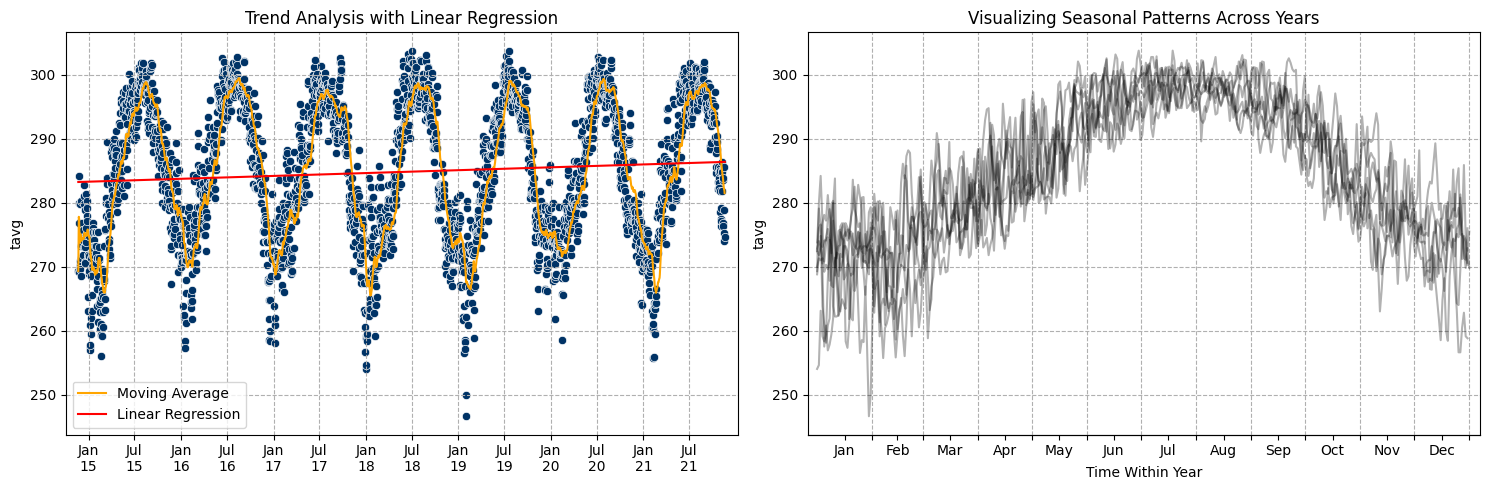

In [6]:
ts_quick_insights(df_train_valid['tavg'], df_train_valid['time'])   

## Heteroscedasticity

The first step is to address the seasonal heteroscedasticity in the data. To do so, we apply a classic variance-stabilizing transformation: the Box–Cox transformation, which smooths the series and facilitates modeling. After applying it, we evaluate whether the transformed target or the original data is easier to forecast. To make this decision, we decompose the series into its seasonal and trend components.


### Box-Cox Transformation
The Box–Cox transformation can automatically select an optimal power parameter $λ$ to stabilize variance, providing a more flexible approach to variance stabilization.

In [7]:
df_train_valid['box_tavg'], lmbda = scipy.stats.boxcox(df_train_valid['tavg'])
lmbda

np.float64(4.83675221708304)

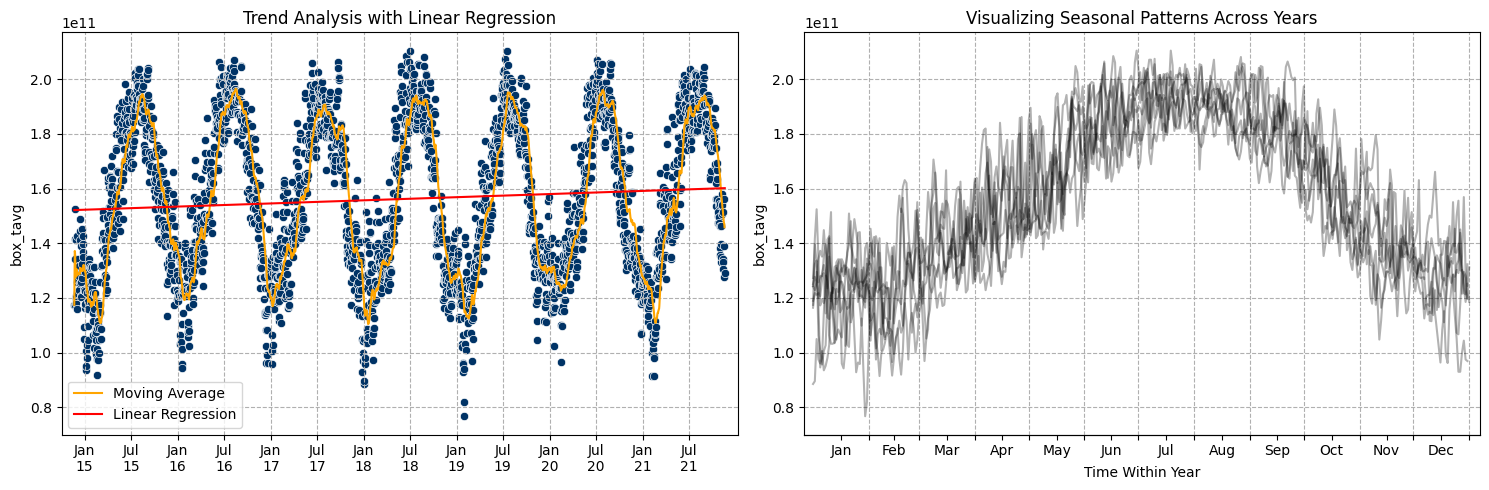

In [8]:
ts_quick_insights(df_train_valid['box_tavg'], df_train_valid['time'])   

The changes in slope and heteroscedasticity do not appear to have changed significantly after the transformation. However, this analysis is purely visual. We will now decompose both the original and transformed data to gather enough information to decide which version we should continue with.

# Trend Decomposition
Although the sanity check did not reveal any clear trend, the exploratory analysis on the training and validation data shows that the series does exhibit some degree of trend. A simple linear regression should be sufficient to remove this trend from the series.

In [9]:
X = pd.DataFrame({'n_days': range(len(df_train_valid))})
X = sm.add_constant(X)

## Original Data

In [10]:
Y = df_train_valid['tavg']
model_original = sm.OLS(Y, X)
results_original = model_original.fit()

In [11]:
print(results_original.summary())

                            OLS Regression Results                            
Dep. Variable:                   tavg   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     17.55
Date:                Thu, 20 Nov 2025   Prob (F-statistic):           2.89e-05
Time:                        11:41:52   Log-Likelihood:                -9739.5
No. Observations:                2555   AIC:                         1.948e+04
Df Residuals:                    2553   BIC:                         1.949e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        283.2454      0.433    653.919      0.0

The estimated slope is positive (0.0012), indicating a very small upward trend over time. Although the effect is minimal, it is still worth addressing.

In [12]:
df_train_valid['tendency'] = results_original.predict()

## Box-Cox Data

In [13]:
Y = df_train_valid['box_tavg']
model_box = sm.OLS(Y, X)
results_box = model_box.fit()

In [14]:
print(results_box.summary())

                            OLS Regression Results                            
Dep. Variable:               box_tavg   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     17.12
Date:                Thu, 20 Nov 2025   Prob (F-statistic):           3.61e-05
Time:                        11:41:52   Log-Likelihood:                -65111.
No. Observations:                2555   AIC:                         1.302e+05
Df Residuals:                    2553   BIC:                         1.302e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.521e+11   1.12e+09    136.020      0.0

The estimated slope (3.138×10⁶) is statistically significant but, as expected after a monotonic variance-stabilizing transformation, its magnitude reflects the scale of the transformed variable rather than a meaningful trend. Similar to the untransformed case, the estimated slope is positive, indicating upward trend over time. Although the effect is minimal, it is still worth addressing.

In [15]:
df_train_valid['box_tendency'] = results_box.predict()

# Seasonal Decomposition
The data exhibit a clear annual seasonal pattern. To remove this pattern, we apply harmonic regression to the model.

In [16]:
n = len(df_train_valid)
t = np.arange(n)

omega1 = (2 * np.pi / 365.25)
omega2 = 2 * (2 * np.pi / 365.25)
omega3 = 3 * (2 * np.pi / 365.25)

We include additional harmonic terms to ensure that all relevant seasonal patterns are captured, selecting those terms whose p-values indicate they are statistically significant for prediction ($< 0.05$).

## Seasonal tavg
Let’s begin by examining the Wavelet of the original data to help identify all seasonal patterns present in the series.

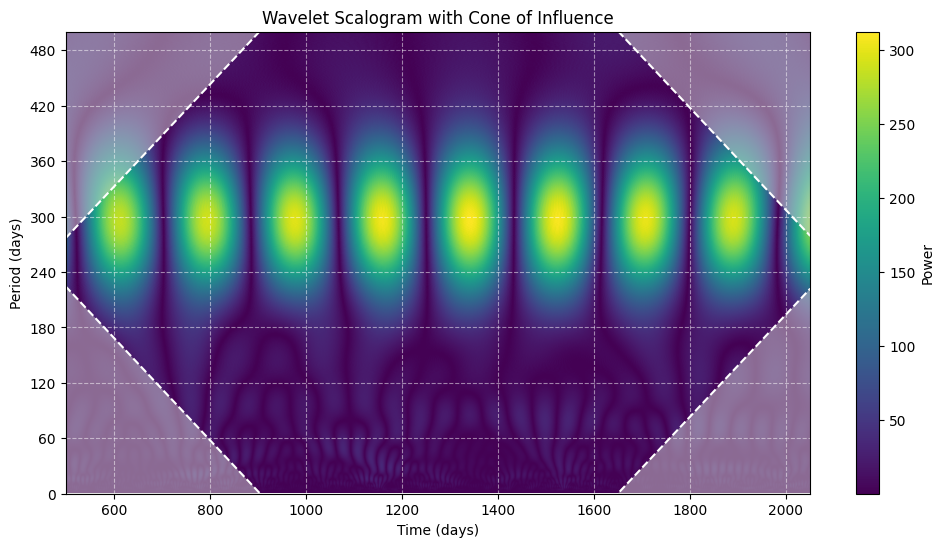

In [17]:
wavelet(df_train_valid['tavg'] - df_train_valid['tendency'], 1, 500)

As we can see, our data contains a well-defined seasonal cycle with a period around 300 days. We expected an annual seasonality of approximately 365 days, the slight discrepancy is likely due to the wavelet’s limited resolution at longer periods or minor deviations from a perfect sinusoidal pattern in the data. Nevertheless, this clear pattern can be easily captured using harmonic regression.

In [18]:
y = df_train_valid['tavg'] - df_train_valid['tendency']
X = np.column_stack([
    np.ones(n), # Intercept           
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.sin(omega2*t),
    np.cos(omega2*t),
    np.sin(omega3*t),
    np.cos(omega3*t)
])

model = sm.OLS(y, X)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     1710.
Date:                Thu, 20 Nov 2025   Prob (F-statistic):               0.00
Time:                        11:41:54   Log-Likelihood:                -7676.6
No. Observations:                2555   AIC:                         1.537e+04
Df Residuals:                    2548   BIC:                         1.541e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0046      0.097     -0.047      0.962      -0.194       0.185
x1           -12.1496      0.137    -88.855      0.000     -12.418     -11.881
x2            -6.6292      0.137    -48.449      0.000      -6.898      -6.361
x3            -0.4618      0.137     -3.377      0.001      -0.730      -0.194
x4            -0.3440      0.137     -2.514      0.012      -0.612      -0.076
x5             0.0747      0.137      0.547      0.585      -0.193       0.343
x6            -0.0041      0.137     -0.030      0.976      -0.272       0.264
==============================================================================
Omnibus:                       47.701   Durbin-Watson:                   0.522
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.103
Skew:                          -0.151   Prob(JB):                     4.04e-18
Kurtosis:                       3.813   Cond. No.                         1.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Using a 5% significance threshold, we determined that components 6 and 5, as well as the constant term, are not statistically significant. We kept the constant for simplicity and for the heteroscedasticity check.

In [19]:
X = np.column_stack([
    np.ones(n),                 
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.sin(omega2*t),
    np.cos(omega2*t)
])

model = sm.OLS(y, X)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     2567.
Date:                Thu, 20 Nov 2025   Prob (F-statistic):               0.00
Time:                        11:41:54   Log-Likelihood:                -7676.7
No. Observations:                2555   AIC:                         1.536e+04
Df Residuals:                    2550   BIC:                         1.539e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0046      0.097     -0.047      0.962      -0.194       0.185
x1           -12.1496      0.137    -88.885      0.000     -12.418     -11.882
x2            -6.6292      0.137    -48.465      0.000      -6.897      -6.361
x3            -0.4618      0.137     -3.378      0.001      -0.730      -0.194
x4            -0.3440      0.137     -2.515      0.012      -0.612      -0.076
==============================================================================
Omnibus:                       48.143   Durbin-Watson:                   0.522
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.916
Skew:                          -0.152   Prob(JB):                     2.69e-18
Kurtosis:                       3.817   Cond. No.                         1.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model includes the fundamental seasonal frequency and its second harmonic, which together capture the main annual cycle and a smaller semiannual oscillation. The R² of 0.801 shows that the harmonic terms explain about 80% of the total variation in the data, confirming that seasonality is by far the dominant component of the series

In [20]:
df_train_valid['seasonal'] = res.predict()
df_train_valid['resid'] = df_train_valid['tavg'] - df_train_valid['tendency'] - df_train_valid['seasonal']

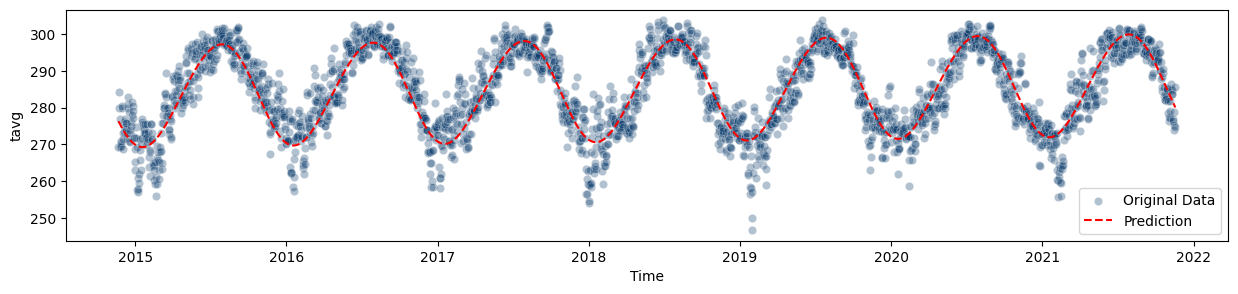

In [21]:
plt.figure(figsize=(15, 3))
sns.scatterplot(x=df_train_valid['time'], y=df_train_valid['tavg'], alpha=0.3, label="Original Data")
sns.lineplot(x=df_train_valid['time'], y=df_train_valid['tendency'] + df_train_valid['seasonal'], linestyle='--', color="red", label="Prediction")
plt.xlabel("Time")
plt.ylabel("tavg")
plt.show()

## Seasonal Box-Cox
The Box–Cox transformation has already been applied. We will now run the wavelet analysis followed by harmonic regression on this transformed data, including all harmonic components.

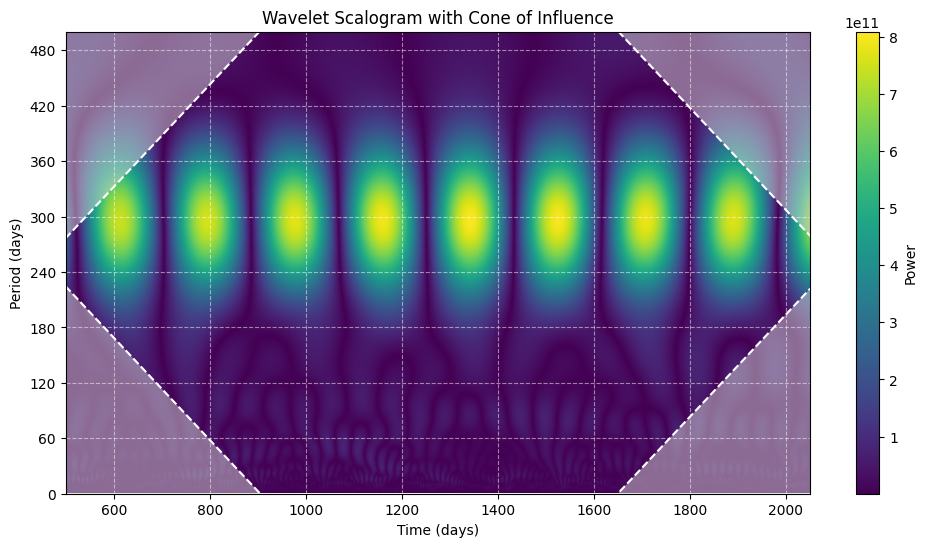

In [22]:
wavelet(df_train_valid['box_tavg'] - df_train_valid['box_tendency'], 1, 500)

The plot here is very similar to that of the original data and the conclusion is the same.

In [23]:
box_y = df_train_valid['box_tavg'] - df_train_valid['box_tendency']
box_X = np.column_stack([
    np.ones(n),                 
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.sin(omega2*t),
    np.cos(omega2*t),
    np.sin(omega3*t),
    np.cos(omega3*t)
])

box_model = sm.OLS(box_y, box_X)
box_res = box_model.fit()
box_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     1882.
Date:                Thu, 20 Nov 2025   Prob (F-statistic):               0.00
Time:                        11:41:57   Log-Likelihood:                -62949.
No. Observations:                2555   AIC:                         1.259e+05
Df Residuals:                    2548   BIC:                         1.260e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.268e+07    2.4e+08     -0.053      0.958   -4.84e+08    4.58e+08
x1          -3.17e+10    3.4e+08    -93.330      0.000   -3.24e+10    -3.1e+10
x2         -1.717e+10    3.4e+08    -50.530      0.000   -1.78e+10   -1.65e+10
x3          1.939e+08    3.4e+08      0.571      0.568   -4.72e+08     8.6e+08
x4         -1.834e+09    3.4e+08     -5.395      0.000    -2.5e+09   -1.17e+09
x5          1.266e+08    3.4e+08      0.373      0.709   -5.39e+08    7.93e+08
x6         -2.492e+08    3.4e+08     -0.733      0.463   -9.16e+08    4.17e+08
==============================================================================
Omnibus:                        9.214   Durbin-Watson:                   0.537
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.291
Skew:                           0.129   Prob(JB):                      0.00961
Kurtosis:                       3.144   Cond. No.                         1.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The statistically significant components are 1, 2, and 4. Component 6 is very close to the predetermined threshold, so we will also treat it as not significant.

In [24]:
box_y = df_train_valid['box_tavg'] - df_train_valid['box_tendency']
box_X = np.column_stack([
    np.ones(n),                 
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.cos(omega2*t)
])

box_model = sm.OLS(box_y, box_X)
box_res = box_model.fit()
box_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     3767.
Date:                Thu, 20 Nov 2025   Prob (F-statistic):               0.00
Time:                        11:41:57   Log-Likelihood:                -62949.
No. Observations:                2555   AIC:                         1.259e+05
Df Residuals:                    2551   BIC:                         1.259e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.25e+07    2.4e+08     -0.052      0.958   -4.83e+08    4.58e+08
x1          -3.17e+10   3.39e+08    -93.367      0.000   -3.24e+10    -3.1e+10
x2         -1.717e+10    3.4e+08    -50.548      0.000   -1.78e+10   -1.65e+10
x3         -1.833e+09    3.4e+08     -5.396      0.000    -2.5e+09   -1.17e+09
==============================================================================
Omnibus:                        8.748   Durbin-Watson:                   0.537
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                8.759
Skew:                           0.129   Prob(JB):                       0.0125
Kurtosis:                       3.125   Cond. No.                         1.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model performs as well as the previous one. The R² of 0.816 indicates that the harmonic terms explain approximately 82% of the total variation in the data.

In [25]:
df_train_valid['box_seasonal'] = box_res.predict()
df_train_valid['box_resid'] = df_train_valid['tavg'] - scipy.special.inv_boxcox(df_train_valid['box_tendency'] + df_train_valid['box_seasonal'], lmbda)

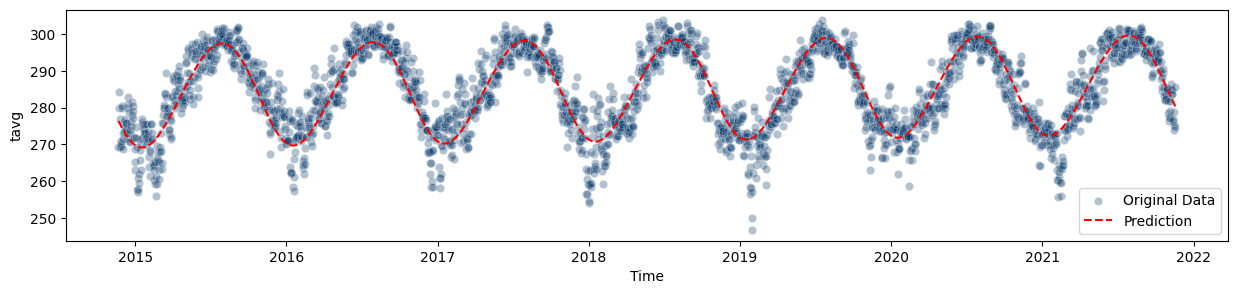

In [26]:
plt.figure(figsize=(15, 3))
sns.scatterplot(x=df_train_valid['time'], y=df_train_valid['tavg'], alpha=0.3, label="Original Data")
sns.lineplot(x=df_train_valid['time'], y=scipy.special.inv_boxcox(df_train_valid['box_tendency'] + df_train_valid['box_seasonal'], lmbda),
             linestyle='--', color="red", label="Prediction")
plt.xlabel("Time")
plt.ylabel("tavg")
plt.show()

# Residual Analysis

Now, let us examine the residuals to determine which data best fits our objective. We will check whether the data remains heteroscedastic and also compare the Mean Squared Error (MSE).

In [27]:
stationary_tests(df_train_valid['resid'])

Augmented Dickey-Fuller (ADF) - p-value: 0.00%
	Ho: Non-Stationarity 
	Ha: Is Stationary
	
Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: 1.00%
	Ho: Is Stationary
	Ha: Non-Stationarity
	


/home/pedro.moura/Pessoal/ChicagoWeatherForecast/src/ts_utils.py:41: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  print(f"Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: {kpss(serie)[1]:.2%}\n"


In [28]:
stationary_tests(df_train_valid['box_resid'])

Augmented Dickey-Fuller (ADF) - p-value: 0.00%
	Ho: Non-Stationarity 
	Ha: Is Stationary
	
Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: 1.00%
	Ho: Is Stationary
	Ha: Non-Stationarity
	


/home/pedro.moura/Pessoal/ChicagoWeatherForecast/src/ts_utils.py:41: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  print(f"Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: {kpss(serie)[1]:.2%}\n"


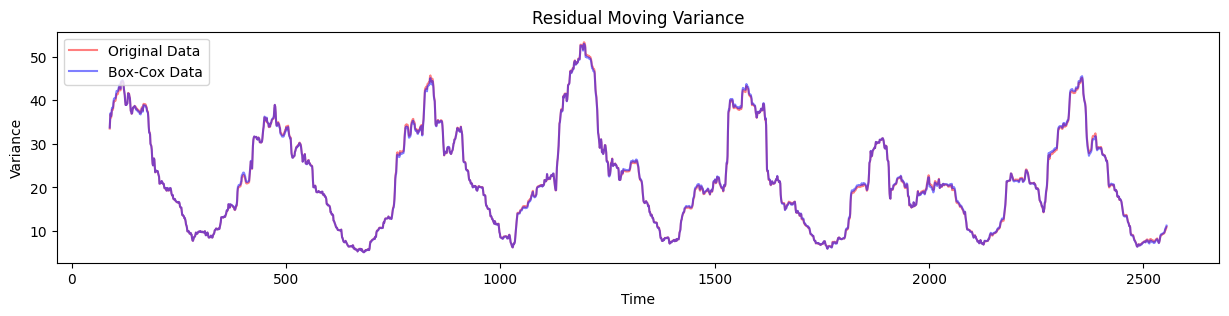

In [29]:
df_train_valid['roll_resid_var'] = df_train_valid['resid'].rolling(90).var()
df_train_valid['roll_box_resid_var'] = df_train_valid['box_resid'].rolling(90).var()
variance_temp = df_train_valid[['roll_resid_var', 'roll_box_resid_var']].dropna()

plt.figure(figsize=(15, 3))
sns.lineplot(x=variance_temp.index, y=variance_temp['roll_resid_var'], alpha=0.5, color="red", label="Original Data")
sns.lineplot(x=variance_temp.index, y=variance_temp['roll_box_resid_var'], alpha=0.5, color="blue", label="Box-Cox Data")
plt.title("Residual Moving Variance")
plt.xlabel("Time")
plt.ylabel("Variance")
plt.show()

In [30]:
(df_train_valid[['box_resid', 'resid']]**2).mean()

box_resid    23.876681
resid        23.838184
dtype: float64

Based on the results above, the transformation does not appear to have smoothed the variance or improved the predictions, making its use unjustified.

Now we will move to the next step: modeling our time series using linear methods such as linear regression, harmonic regression and likely a model from the ARIMA family. This approach allows us to model the trend and seasonal patterns, as well as leverage the autocorrelation in the data to improve our forecast.